# Машинное обучение, ФКН ВШЭ

# Практическое задание 11. Несбалансированные задачи

## Общая информация
Дата выдачи: 24.04.2025

Мягкий дедлайн: 13.05.2025 23:59 MSK

Жесткий дедлайн: 18.05.2025 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-xx-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этом задании мы разберем основные техники работы в задачах, где один из классов занимает существенно меньшую долю выборки, чем остальные. Для простоты мы обойдемся бинарной задачей, тем не менее, во многом данные методы можно перенести и на задачи с б**о**льшим числом классов. Кроме того, вы получите очередной бесценный опыт исследования случайной библиотеки случайных индусов с нуля.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from tqdm.auto import tqdm

**Задание -1 (1 балл)**. EDA

В качестве данных для нашей работы возьмем выложенный на kaggle датасет транзакций, в котором нужно выискивать мошеннические проводки: [клик](https://www.kaggle.com/mlg-ulb/creditcardfraud). Данная задача по определению подходит под несбалансированную, что можно сказать даже без наличия каких-либо данных (понятно, что среди всех транзакций клиентов очень малая часть будет мошеннической).

Загрузим данные, проведем некоторые классические манипуляции.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


In [3]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [4]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


Наши данные были анонимизированы. Мы имеем 30 признаков, из которых 28 - это результаты PCA-преобразования на исходном датасете. Еще 2 признака представляют собой время в секундах, прошедшее с момента первой транзакции в датасете, и размер транзакции. Скажите, какова доля положительных объектов в выборке?

In [5]:
print(f'Доля положительных объектов в выборке:, {round(np.sum(df["Class"] == 1)/len(df)*100, 4)}%')

Доля положительных объектов в выборке:, 0.1727%


Начнем с обработки времени. Секунды сами по себе не несут большой информации о зависимостях в данных, попробуйте по ним создать признаки "час" (от 0 до 23) и "день" (от 0 до ...) в аналогичной манере (принимая первый объект выборки за начальную точку). Сколько дней покрывают данные?

In [6]:
print('Количество дней, которые покрывают данные:', round(np.max(df['Time']) / (60*60*24), 3))

df['Hour'] = ((df['Time'] // (60*60)) % 24).astype(int)
df['Day'] = ((df['Time'] // (60*60*24))).astype(int)

Количество дней, которые покрывают данные: 2.0


Постройте следующие графики:

1. Распределение числа транзакций по каждому часу (line-plot).
2. Распределение доли мошеннических транзакций по каждому часу (line-plot)
3. То же самое для дней (здесь можно использовать bar-plot, так как дней должно быть немного).

Какие выводы можно сделать из графиков? На ваш взгляд, как можно связать полученные нами часы с реальными часами в сутках?

**Ответ:** Мне кажется, что полученные часы можно практически напрямую связать с реальными часами в сутках, так как по описанию датасета он содержит информацию за два дня, и первая транзакция определят точку отсчета времени, и, скорее всего, она была в нулевом часу (когда начался новый день). Промежутком с 00:01 до первой транзакции можно пренебречь, так как транзакции происходят довольно часто, если смотреть на их количество.

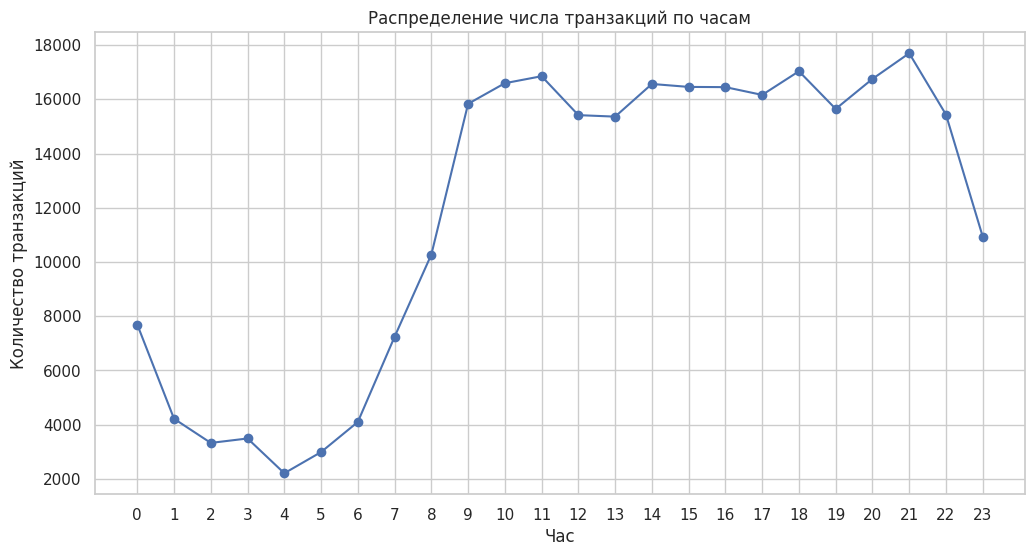

In [7]:
hours_counts = df.groupby('Hour')['Class'].count()

plt.figure(figsize=(12, 6))

plt.plot(hours_counts.index, hours_counts.values, marker='o')
plt.title('Распределение числа транзакций по часам')
plt.xlabel('Час')
plt.ylabel('Количество транзакций')
plt.xticks(range(24))
plt.grid(True)
plt.show()

**Вывод:** Видим, что транзакций ночью значительно меньше, чем днем. Наименьшее число транзакий с 4 до 5 утра, а наибольшее количество - с 21 до 22 вечера.

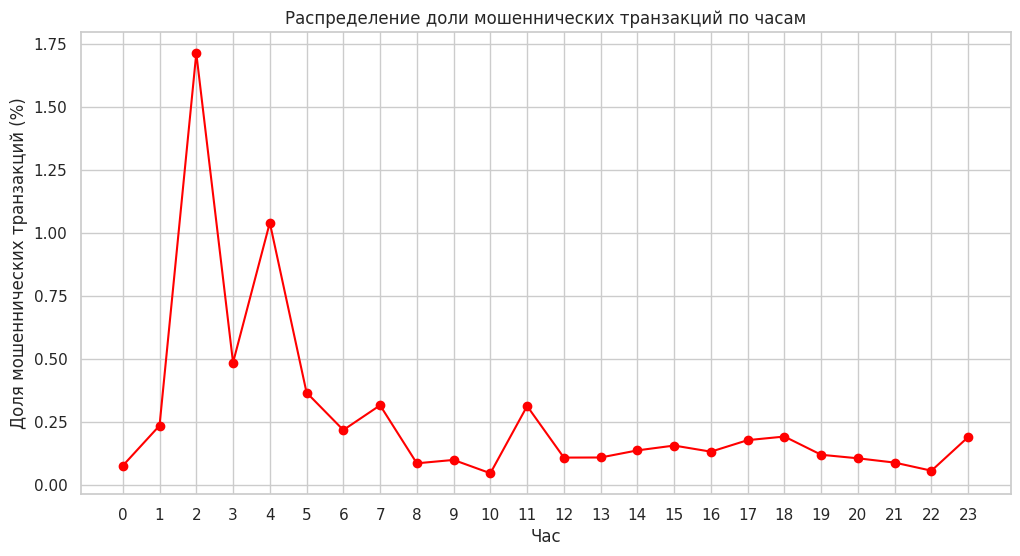

In [8]:
hours_fraud = df.groupby('Hour')['Class'].mean()*100

plt.figure(figsize=(12, 6))

plt.plot(hours_fraud.index, hours_fraud.values, marker='o', color='red')
plt.title('Распределение доли мошеннических транзакций по часам')
plt.xlabel('Час')
plt.ylabel('Доля мошеннических транзакций (%)')
plt.xticks(range(24))
plt.grid(True)
plt.show()

**Вывод:** По графику видно, что наибольшая доля мошеннических транзакций наблюдается ночью, днем их количество мало и практически равномерно распределено. Пиком мошеннических транзакций является время с 2 до 3 ночи, а меньше всего их с 10 до 11 часов утра.

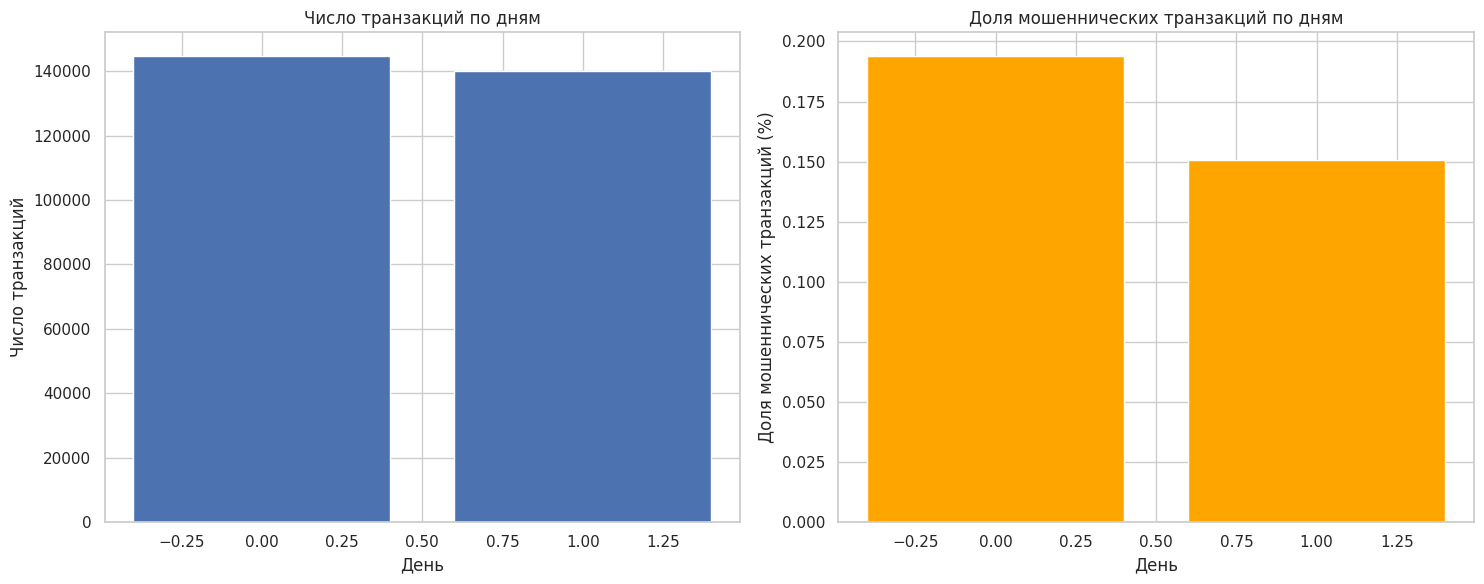

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

days_counts = df.groupby('Day').size()
ax1.bar(days_counts.index, days_counts.values)
ax1.set_title('Число транзакций по дням')
ax1.set_xlabel('День')
ax1.set_ylabel('Число транзакций')

days_fraud = df.groupby('Day')['Class'].mean()*100
ax2.bar(days_fraud.index, days_fraud.values, color='orange')
ax2.set_title('Доля мошеннических транзакций по дням')
ax2.set_xlabel('День')
ax2.set_ylabel('Доля мошеннических транзакций (%)')

plt.tight_layout()
plt.show()

**Вывод:** Можно заметить, что количество транзакций в первый день немного больше, чем во второй, а доля мошеннических транзакций также больше в первый день, но уже значительнее.

С анонимизированными признаками вряд ли можно придумать что-то интересное. Попробуйте (например, с помощью корреляции?) выбрать несколько наиболее важных признаков и поглядеть на различия в их распределении для разных классов.

Выберем 5 наиболее важных признаков с помощью корреляции:

In [10]:
correlations = df.corr()['Class'].abs().sort_values(ascending=False)
correlations

,Class
Class,1.000000
V17,0.326481
V14,0.302544
V12,0.260593
V10,0.216883
V16,0.196539
V3,0.192961
V7,0.187257
V11,0.154876
V4,0.133447


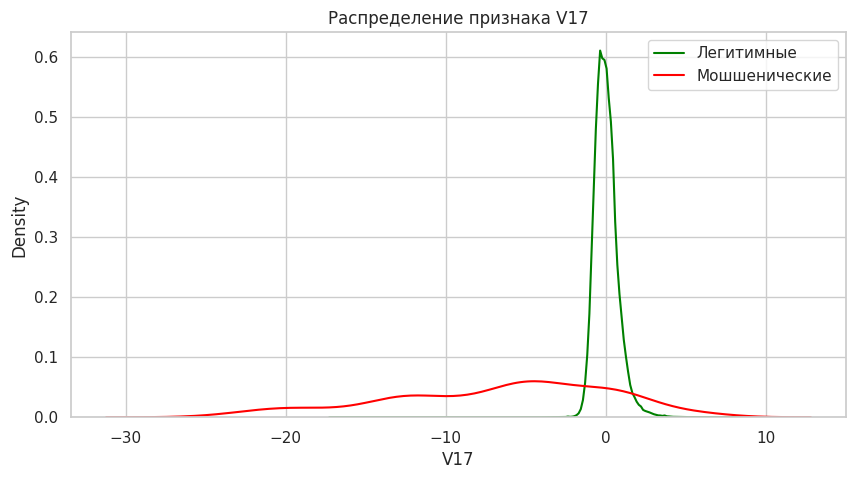

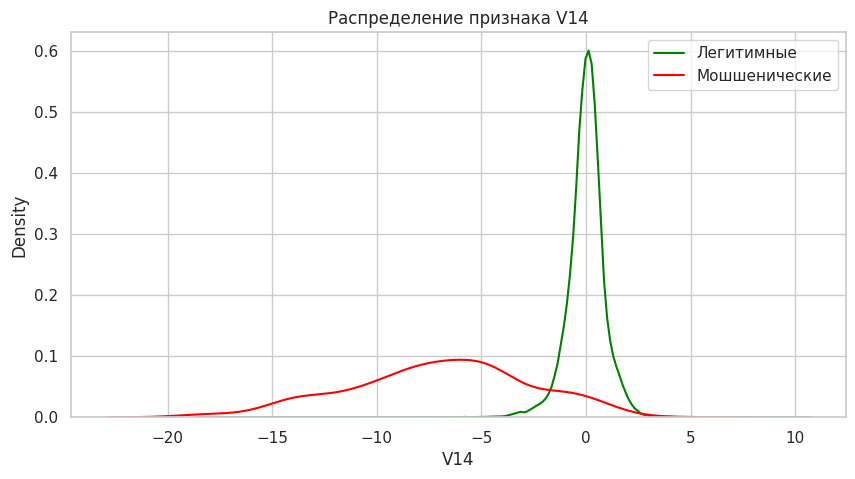

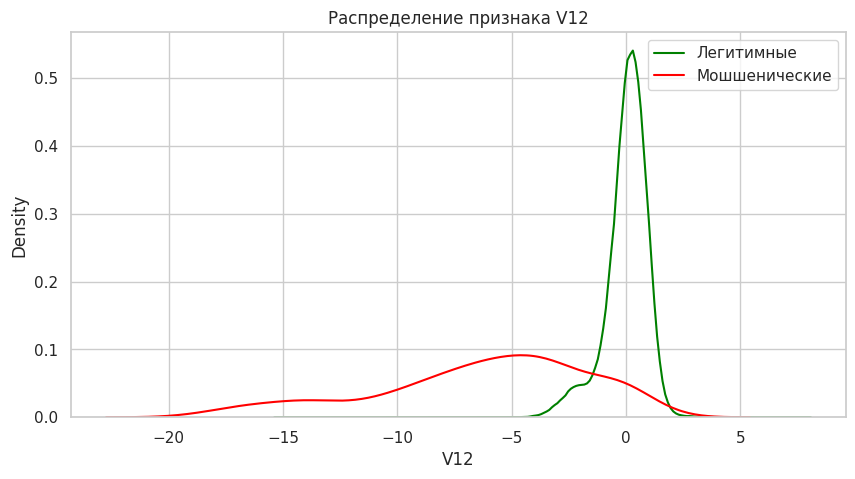

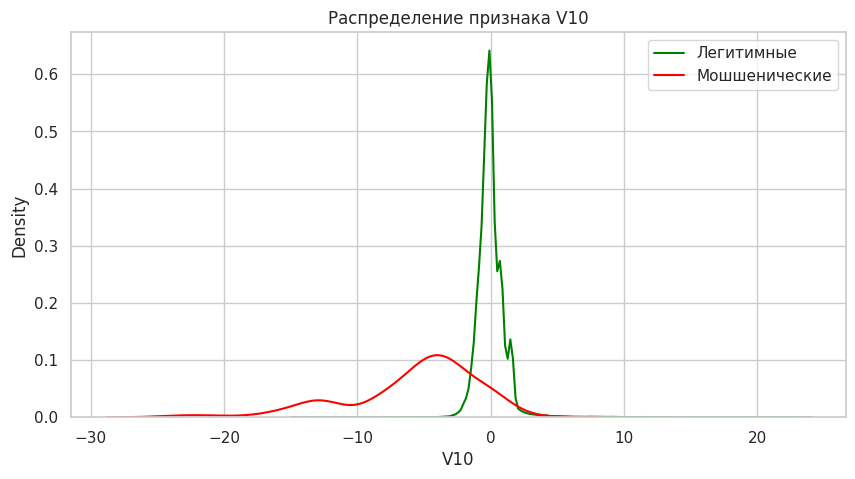

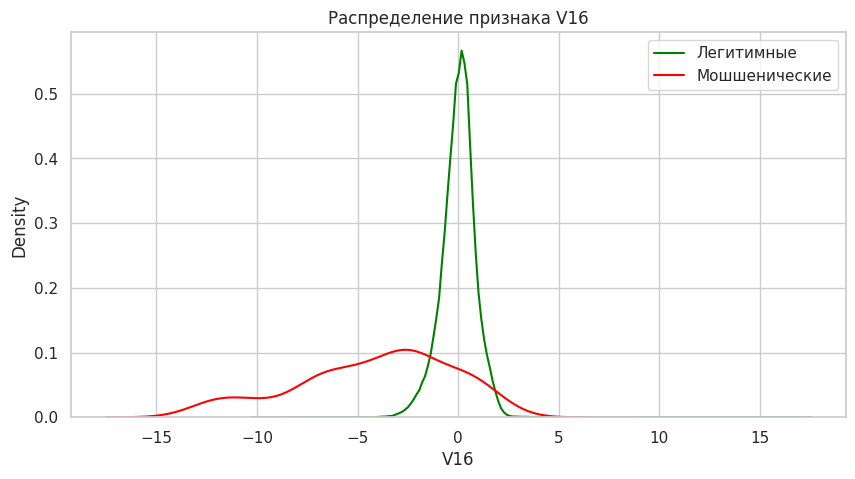

In [11]:
for feature in correlations.index[1:6]:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(df[df['Class'] == 0][feature], label='Легитимные', color='green')
    sns.kdeplot(df[df['Class'] == 1][feature], label='Мошшенические', color='red')
    plt.title(f'Распределение признака {feature}')
    plt.legend()
    plt.show()

**Вывод:** По графикам видно, что для мошеннических транзакций дисперсия этих признаков значительно больше, и происходит смещение в отрицательную часть, когда для легитимных транзакций плотность практически симметрична относительно нуля.

Теперь давайте разделим данные. Отделите хронологически последние 20% транзакций и поделите их пополам (также хронологически, т.е. без перемешивания) на валидационные и тестовые. Это разбиение не совсем корректно (как можно было заметить, мошеннические транзакции имеют разное распределение во времени - по-хорошему, нам стоило бы выделить целые сутки записей как под валидацию, так и под тест), тем не менее, мы не сможем получить больше данных для адекватного контроля, поэтому обойдемся этим.

In [12]:
df = df.sort_values('Time')
df.drop(columns='Time', inplace=True)

train = df[:int(len(df)*0.8)]
other = df[int(len(df)*0.8):]
val = other[:int(len(other)*0.5)]
test = other[int(len(other)*0.5):]

y_train = train['Class']
y_val = val['Class']
y_test = test['Class']
X_train = train.drop(columns='Class')
X_val = val.drop(columns='Class')
X_test = test.drop(columns='Class')

len(X_train) + len(X_val) + len(X_test) == len(df)

True

In [13]:
print(f"Доля тренировочной выборки: {round(len(X_train)/len(df), 5)}")
print(f"Доля валидационной выборки: {round(len(X_val)/len(df), 5)}")
print(f"Доля тестовой выборки: {round(len(X_test)/len(df), 5)}")

Доля тренировочной выборки: 0.8
Доля валидационной выборки: 0.1
Доля тестовой выборки: 0.1


# Часть 1. Несбалансированная классификация.

**Задание 0. (1 балл)**: перед началом работы давайте поговорим о том, как мы будем оценивать качество. Классические метрики для качества классификации чаще всего "ломаются" на задачах с сильным перекосом. Чему будет равно значение accuracy для наивного предсказания (= мажорный класс для каждого объекта)? (можете не отвечать, просто подумайте)

Из курса МО-1 вам уже известно, что мы можем использовать в таких задачах `AUC-PR` и получать адекватные показатели. Можно сказать, что `AUC-PR` представляет собой матожидание `precision` по распределению, заданному выигрышем в `recall` при смене порога.

In [14]:
from sklearn.metrics import precision_recall_curve, auc

def auc_pr(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auc_pr = auc(recall, precision)
    return auc_pr

Тем не менее, существуют и другие, не менее интересные метрики. Одной из таких метрик является коэффициент Каппа Коэна, представляющий собой нормализованную `accuracy`:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Данная метрика служит в качестве меры согласованности между двумя независимыми предсказателями, но ничего не знает про "верные" и "предсказанные" метки (в отличие от многих других метрик машинного обучения). Здесь $p_o$ - доля согласованных предсказаний, а $p_e$ - доля согласованных предсказаний, которая могла бы получиться при случайных ответах предсказателей. В нашем случае это работает так:

• В качестве $p_o$ берем accuracy

• В качестве $p_e$ примем следующую величину - вероятность случайного соглашения позитивных ответов (произведение долей позитивных ответов в обоих предсказаниях) плюс вероятность случайного соглашения негативных ответов (произведение долей негативных ответов в обоих предсказаниях)

Метрика принимает значения от -1 до 1, где 1 - полная согласованность, 0 - согласованность на уровне рандома, -1 - совсем плохо. Как уже говорилось, метрика не различает "верные" и "предсказанные" метки, поэтому является симметричной (можете использовать это для отладки):

In [15]:
def kappa_coef(y_true, y_pred):
    po = sum(y_true == y_pred)/len(y_true)
    pe = sum(y_true == 1)*sum(y_pred == 1)/(len(y_pred))**2 + sum(y_true == 0)*sum(y_pred == 0)/(len(y_pred))**2
    return (po-pe)/(1-pe)

Еще одной метрикой в такой задаче служит коэффициент корреляции Мэтьюза, выражающийся в терминах матрицы ошибок следующим образом:

$$\text{MCC} = \frac{TP\times TN - FP \times FN}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}$$

Метрика принимает значения от -1 до 1, интерпретируемые аналогичным образом.

In [16]:
from sklearn.metrics import confusion_matrix

def mcc(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    upper = (tp*tn) - (fp*fn)
    lower = np.sqrt((tp + fp)*(tp + fn)*(tn+fp)*(tn+fn)) + 1e-20

    return upper/lower

Обратите внимание, что эти метрики вычисляются на бинаризованных предсказаниях, поэтому может иметь смысл дополнительная настройка порога бинаризации.

Давайте проверим, что наши метрики действительно подходят под задачу. Вычислите их значения для наивного предсказания (aka мажорный класс для всех объектов):

In [17]:
print('AUC-PR:', round(auc_pr(df['Class'], np.zeros_like(df['Class'])), 2))
print('Коэффициент Каппа Коэна:', kappa_coef(df['Class'], np.zeros_like(df['Class'])))
print('MCC:', mcc(df['Class'], np.zeros_like(df['Class'])))

AUC-PR: 0.5
Коэффициент Каппа Коэна: 0.0
MCC: 0.0


**Вывод:** Видим, что все метрики указывают на согласованность на уровне рандома, как и должно быть для наивного предсказания.

Давайте запустим бейзлайн-решение для нашей задачи. С чего же начнем? Возьмите `catboost` и обучите его классификатор на наших данных (используйте все признаки). Вычислите значения всех метрик на тестовой части, для контроля переобучения используйте валидационную (здесь и далее везде, где фигурирует `catboost`).

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
catboost = CatBoostClassifier(iterations=100)

categorical_features = ['Hour', 'Day']
catboost.fit(X_train, y_train, cat_features=categorical_features)

Learning rate set to 0.5
0:	learn: 0.0393640	total: 153ms	remaining: 15.2s
1:	learn: 0.0059716	total: 313ms	remaining: 15.3s
2:	learn: 0.0033023	total: 478ms	remaining: 15.5s
3:	learn: 0.0028715	total: 657ms	remaining: 15.8s
4:	learn: 0.0026455	total: 850ms	remaining: 16.1s
5:	learn: 0.0025489	total: 1.02s	remaining: 16s
6:	learn: 0.0024552	total: 1.29s	remaining: 17.2s
7:	learn: 0.0023584	total: 1.63s	remaining: 18.8s
8:	learn: 0.0023070	total: 1.95s	remaining: 19.7s
9:	learn: 0.0022043	total: 2.3s	remaining: 20.7s
10:	learn: 0.0021390	total: 2.61s	remaining: 21.2s
11:	learn: 0.0020205	total: 2.97s	remaining: 21.8s
12:	learn: 0.0019212	total: 3.3s	remaining: 22.1s
13:	learn: 0.0018580	total: 3.61s	remaining: 22.2s
14:	learn: 0.0018214	total: 3.95s	remaining: 22.4s
15:	learn: 0.0017952	total: 4.22s	remaining: 22.1s
16:	learn: 0.0017697	total: 4.37s	remaining: 21.3s
17:	learn: 0.0017441	total: 4.53s	remaining: 20.7s
18:	learn: 0.0017247	total: 4.7s	remaining: 20s
19:	learn: 0.0017023	to

In [ ]:
print('val AUC-PR:', round(auc_pr(y_val, catboost.predict(X_val)), 3))
print('test AUC-PR:', round(auc_pr(y_test, catboost.predict(X_test)), 3))

val AUC-PR: 0.844
test AUC-PR: 0.76


In [ ]:
print('val kappa:', round(kappa_coef(y_val, catboost.predict(X_val)), 3))
print('test kappa:', round(kappa_coef(y_test, catboost.predict(X_test)), 3))

val kappa: 0.83
test kappa: 0.722


In [ ]:
print('val mcc:', round(mcc(y_val, catboost.predict(X_val)), 3))
print('test mcc:', round(mcc(y_test, catboost.predict(X_test)), 3))

val mcc: 0.836
test mcc: 0.741


**Вывод:** Результаты оказались средними как на валидационной, так и на тестовой выборке.

Если вы все сделали правильно, у вас должны были получиться значения в районе 0.7.

**Задание 1. (1 балл)**. Многие реализации методов предлагают встроенные способы для борьбы с нашей проблемой. Самое часто встречающееся решение - просто добавить вес в функции потерь для минорного класса (таким образом, ошибка на объекте минорного класса будет весить больше, чем для мажорного). В `catboost` это также реализовано, причем для бинарной задачи это можно сделать целыми двумя способами (можете выбрать любой, на свой вкус, автор задания предпочитает отдельный скейлинг для минорного класса). Чаще всего в качестве веса берется отношение числа объектов мажорного класса к числу минорного. Попробуйте обучить модель с таким скалированием и сравните метрики на тестовой части с бейзлайном.

In [ ]:
class_counts = np.bincount(df['Class'])
minority_scale = class_counts[0]/class_counts[1]

catboost_weighted = CatBoostClassifier(iterations=100, class_weights=[1, minority_scale])
catboost_weighted.fit(X_train, y_train, cat_features=categorical_features)

Learning rate set to 0.5
0:	learn: 0.2419076	total: 193ms	remaining: 19.1s
1:	learn: 0.1561986	total: 372ms	remaining: 18.2s
2:	learn: 0.1159812	total: 571ms	remaining: 18.5s
3:	learn: 0.0890848	total: 743ms	remaining: 17.8s
4:	learn: 0.0718026	total: 934ms	remaining: 17.8s
5:	learn: 0.0638206	total: 1.1s	remaining: 17.3s
6:	learn: 0.0562106	total: 1.29s	remaining: 17.1s
7:	learn: 0.0502530	total: 1.44s	remaining: 16.6s
8:	learn: 0.0448007	total: 1.65s	remaining: 16.7s
9:	learn: 0.0372305	total: 1.85s	remaining: 16.6s
10:	learn: 0.0336419	total: 2.02s	remaining: 16.3s
11:	learn: 0.0308189	total: 2.19s	remaining: 16.1s
12:	learn: 0.0285624	total: 2.37s	remaining: 15.9s
13:	learn: 0.0216265	total: 2.57s	remaining: 15.8s
14:	learn: 0.0186861	total: 2.76s	remaining: 15.6s
15:	learn: 0.0164463	total: 2.93s	remaining: 15.4s
16:	learn: 0.0149204	total: 3.1s	remaining: 15.2s
17:	learn: 0.0126281	total: 3.28s	remaining: 15s
18:	learn: 0.0111425	total: 3.46s	remaining: 14.7s
19:	learn: 0.0106850

In [ ]:
print('val AUC-PR:', round(auc_pr(y_val, catboost_weighted.predict(X_val)), 3))
print('test AUC-PR:', round(auc_pr(y_test, catboost_weighted.predict(X_test)), 3))

val AUC-PR: 0.77
test AUC-PR: 0.591


In [ ]:
print('val kappa:', round(kappa_coef(y_val, catboost_weighted.predict(X_val)), 3))
print('test kappa:', round(kappa_coef(y_test, catboost_weighted.predict(X_test)), 3))

val kappa: 0.7688088214304469
test kappa: 0.5765456595020853


In [ ]:
print('val mcc:', round(mcc(y_val, catboost_weighted.predict(X_val)), 3))
print('test mcc:', round(mcc(y_test, catboost_weighted.predict(X_test)), 3))

val mcc: 0.769
test mcc: 0.584


**Вывод:** Результаты стали сильно хуже.

Поскольку данный вес будет являться гиперпараметром метода, было бы опрометчиво остановиться на одном значении (тем более, с большой вероятностью у вас все сломалось). Запустите перебор для этого гиперпараметра на валидационной выборке (используйте `PR-AUC`), подберите оптимальный порог бинаризации для $\kappa$ или $\text{MCC}$. Для лучшего найденного веса и порога вычислите все метрики на тестовой части.

При этом можете также проверить отдельное скалирование в большую сторону для мажорного класса (т.е. веса минорного сделать меньше 1) и экстремальные скалирования (т.е. веса минорного больше, чем в начале этого задания). Какой вес получился оптимальным?

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.7 MB/s eta 0:00:00


In [ ]:
import optuna

def objective(trial):
    minority_scale = trial.suggest_float('minority_scale', 1, 100)

    categorical_features = ['Hour', 'Day']

    catboost_weighted = CatBoostClassifier(iterations=100, class_weights=[1, minority_scale])
    catboost_weighted.fit(X_train, y_train, cat_features=categorical_features, verbose=False)
    val_pred = catboost_weighted.predict(X_val)
    return auc_pr(y_val, val_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_param = study.best_params
print("Лучший параметр minority_scale:", best_param)

[I 2025-05-07 06:55:54,429] A new study created in memory with name: no-name-83ab6700-f476-49f7-aa52-3cd714294ca4
[I 2025-05-07 06:56:17,684] Trial 0 finished with value: 0.8556703061888992 and parameters: {'minority_scale': 9.076792602674669}. Best is trial 0 with value: 0.8556703061888992.
[I 2025-05-07 06:56:39,668] Trial 1 finished with value: 0.8537771890801683 and parameters: {'minority_scale': 10.339770906804715}. Best is trial 0 with value: 0.8556703061888992.
[I 2025-05-07 06:57:00,100] Trial 2 finished with value: 0.8529122104995759 and parameters: {'minority_scale': 18.82866860216168}. Best is trial 0 with value: 0.8556703061888992.
[I 2025-05-07 06:57:20,478] Trial 3 finished with value: 0.8637473056369966 and parameters: {'minority_scale': 97.31222259497203}. Best is trial 3 with value: 0.8637473056369966.
[I 2025-05-07 06:57:40,730] Trial 4 finished with value: 0.8321321674351467 and parameters: {'minority_scale': 90.42431934484718}. Best is trial 3 with value: 0.86374730

Лучший параметр minority_scale: {'minority_scale': 19.79571134120975}


In [ ]:
best_minority_scale = study.best_params['minority_scale']
categorical_features = ['Hour', 'Day']

catboost_weighted = CatBoostClassifier(iterations=100, class_weights=[1, best_minority_scale])
catboost_weighted.fit(X_train, y_train, cat_features=categorical_features, verbose=False)

def objective(trial):
    probability_threshold = trial.suggest_float('probability_threshold', 0, 1)
    catboost_weighted.set_probability_threshold(probability_threshold)
    val_pred = catboost_weighted.predict(X_val)
    return mcc(y_val, val_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_param = study.best_params['probability_threshold']
print("Лучший параметр probability_threshold:", best_param)

[I 2025-05-07 07:04:14,442] A new study created in memory with name: no-name-a53d8a64-dcf9-4152-841a-081e0d5f4723
[I 2025-05-07 07:04:14,486] Trial 0 finished with value: 0.8578636046566044 and parameters: {'probability_threshold': 0.7082735206981491}. Best is trial 0 with value: 0.8578636046566044.
[I 2025-05-07 07:04:14,528] Trial 1 finished with value: 0.8578636046566044 and parameters: {'probability_threshold': 0.6072659529675746}. Best is trial 0 with value: 0.8578636046566044.
[I 2025-05-07 07:04:14,570] Trial 2 finished with value: 0.800675317593141 and parameters: {'probability_threshold': 0.9861696589574273}. Best is trial 0 with value: 0.8578636046566044.
[I 2025-05-07 07:04:14,620] Trial 3 finished with value: 0.8578636046566044 and parameters: {'probability_threshold': 0.7403678904280138}. Best is trial 0 with value: 0.8578636046566044.
[I 2025-05-07 07:04:14,663] Trial 4 finished with value: 0.8324091849993764 and parameters: {'probability_threshold': 0.10885641104237298}.

Лучший параметр probability_threshold: 0.7082735206981491


In [ ]:
best_probability_threshold = study.best_params['probability_threshold']

catboost_weighted = CatBoostClassifier(iterations=100, class_weights=[1, minority_scale])
catboost_weighted.fit(X_train, y_train, cat_features=categorical_features, verbose=True)
catboost_weighted.set_probability_threshold(best_probability_threshold)

Learning rate set to 0.5
0:	learn: 0.2419076	total: 188ms	remaining: 18.6s
1:	learn: 0.1561986	total: 363ms	remaining: 17.8s
2:	learn: 0.1159812	total: 548ms	remaining: 17.7s
3:	learn: 0.0890848	total: 730ms	remaining: 17.5s
4:	learn: 0.0718026	total: 926ms	remaining: 17.6s
5:	learn: 0.0638206	total: 1.12s	remaining: 17.5s
6:	learn: 0.0562106	total: 1.32s	remaining: 17.6s
7:	learn: 0.0502530	total: 1.51s	remaining: 17.4s
8:	learn: 0.0448007	total: 1.73s	remaining: 17.5s
9:	learn: 0.0372305	total: 1.93s	remaining: 17.4s
10:	learn: 0.0336419	total: 2.14s	remaining: 17.3s
11:	learn: 0.0308189	total: 2.33s	remaining: 17.1s
12:	learn: 0.0285624	total: 2.51s	remaining: 16.8s
13:	learn: 0.0216265	total: 2.69s	remaining: 16.5s
14:	learn: 0.0186861	total: 2.88s	remaining: 16.3s
15:	learn: 0.0164463	total: 3.08s	remaining: 16.2s
16:	learn: 0.0149204	total: 3.25s	remaining: 15.9s
17:	learn: 0.0126281	total: 3.45s	remaining: 15.7s
18:	learn: 0.0111425	total: 3.64s	remaining: 15.5s
19:	learn: 0.010

In [ ]:
print('test AUC-PR:', round(auc_pr(y_test, catboost_weighted.predict(X_test)), 3))
print('test kappa:', round(kappa_coef(y_test, catboost_weighted.predict(X_test)), 3))
print('test mcc:', round(mcc(y_test, catboost_weighted.predict(X_test)), 3))

test AUC-PR: 0.654
test kappa: 0.652
test mcc: 0.653


**Вывод:** В данном случае результаты лучше на 6-8% процентов по каждой метрике по сравнению с предыдущей моделью, но все равно ниже на 8-11% относительно безлайна.  

**Задание 2. (1 балл)**. На самом деле, то, что мы сейчас делали, очень схоже с другой распространенной техникой - оверсэмплингом. Фактически, мы можем продублировать все объекты минорного класса и получить тот же эффект, какой был бы при использовании веса, равного 2. Тем не менее, такой подход - это лишь малая часть того, что мы можем проделать с целью повысить число объектов минорного класса.

Для продолжения работы установим библиотеку [imbalanced-learn](https://imbalanced-learn.org/stable/):

In [ ]:
!pip3 install imbalanced-learn
# conda install -c conda-forge imbalanced-learn

Первый метод, которым мы воспользуемся, называется SMOTE (его вы уже разбирали на лекции). Кратко напомним суть: мы выбираем случайного кандидата среди $k$ ближайших соседей объекта минорного класса, затем берем точку на отрезке между двумя объектами (т.е. выпуклую комбинацию со случайными коэффициентами) и добавляем в выборку.

In [ ]:
from imblearn.over_sampling import SMOTE

Используйте SMOTE для ресэмплинга обучающей выборки, на новой выборке обучите модель (вес положительных объектов скалировать не нужно). Замерьте качество на тестовой выборке (**важно!** не преобразовывайте валидационную и тестовую выборку никак - мы не хотим отслеживать качество на объектах, которых в реальности не существует). Сравните полное выравнивание выборки с частичным (т.е. таким, что баланс классов улучшается, но не достигает равенства - скажем, 1:2 и 1:10).

In [ ]:
smote = SMOTE(sampling_strategy=1, random_state=152)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

catboost_sm = CatBoostClassifier(iterations=100)

categorical_features = ['Hour', 'Day']
catboost_sm.fit(X_train_res, y_train_res, cat_features=categorical_features)

print('val AUC-PR:', round(auc_pr(y_val, catboost_sm.predict(X_val)), 3))
print('test AUC-PR:', round(auc_pr(y_test, catboost_sm.predict(X_test)), 3))
print('val kappa:', round(kappa_coef(y_val, catboost_sm.predict(X_val)), 3))
print('test kappa:', round(kappa_coef(y_test, catboost_sm.predict(X_test)), 3))
print('val mcc:', round(mcc(y_val, catboost_sm.predict(X_val)), 3))
print('test mcc:', round(mcc(y_test, catboost_sm.predict(X_test)), 3))

Learning rate set to 0.5
0:	learn: 0.1686037	total: 553ms	remaining: 54.7s
1:	learn: 0.1067665	total: 1.21s	remaining: 59.3s
2:	learn: 0.0873904	total: 1.89s	remaining: 1m
3:	learn: 0.0721066	total: 2.5s	remaining: 1m
4:	learn: 0.0622279	total: 3.1s	remaining: 59s
5:	learn: 0.0557203	total: 3.44s	remaining: 53.8s
6:	learn: 0.0504237	total: 3.76s	remaining: 50s
7:	learn: 0.0463566	total: 4.08s	remaining: 47s
8:	learn: 0.0415470	total: 4.43s	remaining: 44.8s
9:	learn: 0.0365527	total: 4.76s	remaining: 42.8s
10:	learn: 0.0337769	total: 5.09s	remaining: 41.2s
11:	learn: 0.0305026	total: 5.41s	remaining: 39.7s
12:	learn: 0.0285466	total: 5.74s	remaining: 38.4s
13:	learn: 0.0261475	total: 6.05s	remaining: 37.2s
14:	learn: 0.0235572	total: 6.36s	remaining: 36s
15:	learn: 0.0215038	total: 6.72s	remaining: 35.3s
16:	learn: 0.0204086	total: 7.03s	remaining: 34.3s
17:	learn: 0.0187718	total: 7.34s	remaining: 33.4s
18:	learn: 0.0173446	total: 7.71s	remaining: 32.9s
19:	learn: 0.0164756	total: 8.03

In [ ]:
smote = SMOTE(sampling_strategy=0.5, random_state=152)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

catboost_sm = CatBoostClassifier(iterations=100)

categorical_features = ['Hour', 'Day']
catboost_sm.fit(X_train_res, y_train_res, cat_features=categorical_features)

print('val AUC-PR:', round(auc_pr(y_val, catboost_sm.predict(X_val)), 3))
print('test AUC-PR:', round(auc_pr(y_test, catboost_sm.predict(X_test)), 3))
print('val kappa:', round(kappa_coef(y_val, catboost_sm.predict(X_val)), 3))
print('test kappa:', round(kappa_coef(y_test, catboost_sm.predict(X_test)), 3))
print('val mcc:', round(mcc(y_val, catboost_sm.predict(X_val)), 3))
print('test mcc:', round(mcc(y_test, catboost_sm.predict(X_test)), 3))

Learning rate set to 0.5
0:	learn: 0.1737060	total: 542ms	remaining: 53.7s
1:	learn: 0.1002018	total: 997ms	remaining: 48.9s
2:	learn: 0.0779647	total: 1.62s	remaining: 52.5s
3:	learn: 0.0678905	total: 2.15s	remaining: 51.5s
4:	learn: 0.0610129	total: 2.62s	remaining: 49.7s
5:	learn: 0.0553569	total: 3.22s	remaining: 50.5s
6:	learn: 0.0494957	total: 4.11s	remaining: 54.6s
7:	learn: 0.0438278	total: 4.65s	remaining: 53.5s
8:	learn: 0.0403266	total: 5.05s	remaining: 51.1s
9:	learn: 0.0353353	total: 5.54s	remaining: 49.8s
10:	learn: 0.0322359	total: 5.93s	remaining: 48s
11:	learn: 0.0294884	total: 6.44s	remaining: 47.2s
12:	learn: 0.0263498	total: 6.83s	remaining: 45.7s
13:	learn: 0.0245850	total: 7.36s	remaining: 45.2s
14:	learn: 0.0236459	total: 7.92s	remaining: 44.9s
15:	learn: 0.0215921	total: 8.65s	remaining: 45.4s
16:	learn: 0.0201430	total: 9.35s	remaining: 45.7s
17:	learn: 0.0176615	total: 10s	remaining: 45.7s
18:	learn: 0.0158796	total: 10.6s	remaining: 45.2s
19:	learn: 0.0144141

In [ ]:
smote = SMOTE(sampling_strategy=0.1, random_state=152)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

catboost_sm = CatBoostClassifier(iterations=100)

categorical_features = ['Hour', 'Day']
catboost_sm.fit(X_train_res, y_train_res, cat_features=categorical_features)

print('val AUC-PR:', round(auc_pr(y_val, catboost_sm.predict(X_val)), 3))
print('test AUC-PR:', round(auc_pr(y_test, catboost_sm.predict(X_test)), 3))
print('val kappa:', round(kappa_coef(y_val, catboost_sm.predict(X_val)), 3))
print('test kappa:', round(kappa_coef(y_test, catboost_sm.predict(X_test)), 3))
print('val mcc:', round(mcc(y_val, catboost_sm.predict(X_val)), 3))
print('test mcc:', round(mcc(y_test, catboost_sm.predict(X_test)), 3))

Learning rate set to 0.5
0:	learn: 0.1114247	total: 186ms	remaining: 18.4s
1:	learn: 0.0558737	total: 371ms	remaining: 18.2s
2:	learn: 0.0395257	total: 561ms	remaining: 18.1s
3:	learn: 0.0337726	total: 752ms	remaining: 18s
4:	learn: 0.0306979	total: 964ms	remaining: 18.3s
5:	learn: 0.0274004	total: 1.29s	remaining: 20.2s
6:	learn: 0.0259987	total: 1.46s	remaining: 19.4s
7:	learn: 0.0241066	total: 1.78s	remaining: 20.5s
8:	learn: 0.0222847	total: 2.18s	remaining: 22s
9:	learn: 0.0212777	total: 2.56s	remaining: 23s
10:	learn: 0.0201584	total: 2.89s	remaining: 23.4s
11:	learn: 0.0188783	total: 3.25s	remaining: 23.8s
12:	learn: 0.0179433	total: 3.58s	remaining: 24s
13:	learn: 0.0173528	total: 3.94s	remaining: 24.2s
14:	learn: 0.0162546	total: 4.3s	remaining: 24.4s
15:	learn: 0.0153825	total: 4.64s	remaining: 24.3s
16:	learn: 0.0142994	total: 4.84s	remaining: 23.6s
17:	learn: 0.0132955	total: 5.08s	remaining: 23.2s
18:	learn: 0.0118417	total: 5.3s	remaining: 22.6s
19:	learn: 0.0104908	total

**Вывод:** Видим, что оптимальным является частичное выравнивание выборки: 1 к 10, и в таком случае качество повышается на 1-2 % относительно безлайна, но многое зависит от random_state.

**Бонус (1.5 балла)**. Для vanilla SMOTE существуют некоторые модификации, часть из которых была реализована в библиотеке imblearn. Во время лекций/семинаров эти модификации не рассматривались, тем не менее, мы все равно их исследуем.

Найдите статьи о следующих методах и попробуйте вкратце сформулировать, в чем их основная идея (сделайте так, чтобы человек, знакомый с машинным обучением в целом, но не слышавший конкретно про это смог понять):

BorderlineSMOTE - вместо равномерного генерации новых миноритарных объектов, метод фокусируется на пограничных примерах - тех, что находятся рядом с большинством, потому что именно на границе между классами ванильная модель чаще всего делает ошибки.

SVM-SMOTE - метод использует границу, построенную с помощью SVM, чтобы определить, где именно нужно создавать новые синтетические точки. Сначала обучается SVM для разделения классов, затем новые миноритарные примеры генерируются вблизи опорных векторов, особенно тех, что лежат ближе к границе разделения.

K-Means-SMOTE - перед созданием синтетических объектов метод сначала кластеризует данные миноритарного класса с помощью алгоритма K-Means, чтобы определить, где в пространстве данных миноритарные примеры наиболее значимы и не создавать дубликаты в менее важной или шумной области.

ADASYN - метод адаптивно решает, где нужно больше синтетических данных.Чем труднее классификатору распознать миноритарные примеры (например, они окружены множеством объектов другого класса), тем больше новых точек создаётся рядом с ними.

Теперь попробуйте сравнить качество всех методов на наших данных.

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, ADASYN

methods = {
    "Vanilla SMOTE": SMOTE(random_state=152),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=152),
    "SVM-SMOTE": SVMSMOTE(random_state=152),
    "K-Means-SMOTE": KMeansSMOTE(random_state=152, cluster_balance_threshold=0.004),
    "ADASYN": ADASYN(random_state=152)
}

for name, sampler in methods.items():
    X_train_res, y_train_res = sampler.fit_resample(X_train, y_train)

    catboost_sm = CatBoostClassifier(iterations=100, verbose=False)

    categorical_features = ['Hour', 'Day']
    catboost_sm.fit(X_train_res, y_train_res, cat_features=categorical_features)
    print(f"\n=== {name} ===")
    print('val AUC-PR:', round(auc_pr(y_val, catboost_sm.predict(X_val)), 3))
    print('test AUC-PR:', round(auc_pr(y_test, catboost_sm.predict(X_test)), 3))
    print('val kappa:', round(kappa_coef(y_val, catboost_sm.predict(X_val)), 3))
    print('test kappa:', round(kappa_coef(y_test, catboost_sm.predict(X_test)), 3))
    print('val mcc:', round(mcc(y_val, catboost_sm.predict(X_val)), 3))
    print('test mcc:', round(mcc(y_test, catboost_sm.predict(X_test)), 3))


=== Vanilla SMOTE ===
val AUC-PR: 0.823
test AUC-PR: 0.671
val kappa: 0.82
test kappa: 0.666
val mcc: 0.821
test mcc: 0.669

=== BorderlineSMOTE ===
val AUC-PR: 0.793
test AUC-PR: 0.64
val kappa: 0.792
test kappa: 0.627
val mcc: 0.792
test mcc: 0.633

=== SVM-SMOTE ===
val AUC-PR: 0.843
test AUC-PR: 0.64
val kappa: 0.84
test kappa: 0.627
val mcc: 0.841
test mcc: 0.633

=== K-Means-SMOTE ===
val AUC-PR: 0.803
test AUC-PR: 0.619
val kappa: 0.8
test kappa: 0.612
val mcc: 0.801
test mcc: 0.615

=== ADASYN ===
val AUC-PR: 0.755
test AUC-PR: 0.667
val kappa: 0.754
test kappa: 0.666
val mcc: 0.754
test mcc: 0.667


**Вывод:** Видим, что на наших данных BorderlineSMOTE и SVM-SMOTE выдали одинаковые результаты на тестовой выборке, но на валидационной вторая модель выдает качество выше. Наилучшие результаты на тестовой выборке у Vanilla SMOTE и ADASYN, но ванильная модель лучше и на валидационной. Худшие результаты на тестовой выборке выдает K-Means-SMOTE.

Таким образом, Vanilla SMOTE оказался наилучшим для наших данных, однако это лишь подчёркивает важность подбора подходящих гиперпараметров для модицированных методов.

**Задание 3. (1 балл)**. До этого момента все наши решения концентрировались на работе с минорным классом. Теперь давайте попробуем зайти с другой стороны. Может быть, для восстановления закономерностей нам не нужно столько объектов мажорного класса, и они просто засоряют нам выборку лишней информацией?

Для решения этой проблемы существуют методы андерсэмплинга. Самое простое, что можно придумать - удалять точки мажорного класса, пока мы не получим приемлемый баланс. Протестируйте следующий метод и постройте графики достигаемых значений метрик от баланса классов и от отношения размеров исходной и пересэмпленной выборки:

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
from tqdm import tqdm

ratios = np.linspace(0.01, 1.0, 20)
metrics = {
    'auc_pr': [],
    'kappa': [],
    'mcc': [],
    'sample_balance': [],
    'sample_ratio': []
}

for ratio in tqdm(ratios):
    rus = RandomUnderSampler(sampling_strategy={0: int(sum(y_train == 0) * ratio)}, random_state=52)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

    catboost_rus = CatBoostClassifier(iterations=100, verbose=False)

    categorical_features = ['Hour', 'Day']
    catboost_rus.fit(X_train_res, y_train_res, cat_features=categorical_features)

    metrics['auc_pr'].append(auc_pr(y_val, catboost_rus.predict(X_val)))
    metrics['kappa'].append(kappa_coef(y_val, catboost_rus.predict(X_val)))
    metrics['mcc'].append(mcc(y_val, catboost_rus.predict(X_val)))
    metrics['sample_balance'].append(sum(y_train_res == 0)/sum(y_train_res == 1))
    metrics['sample_ratio'].append(len(X_train)/len(X_train_res))

100%|██████████| 20/20 [03:47<00:00, 11.37s/it]


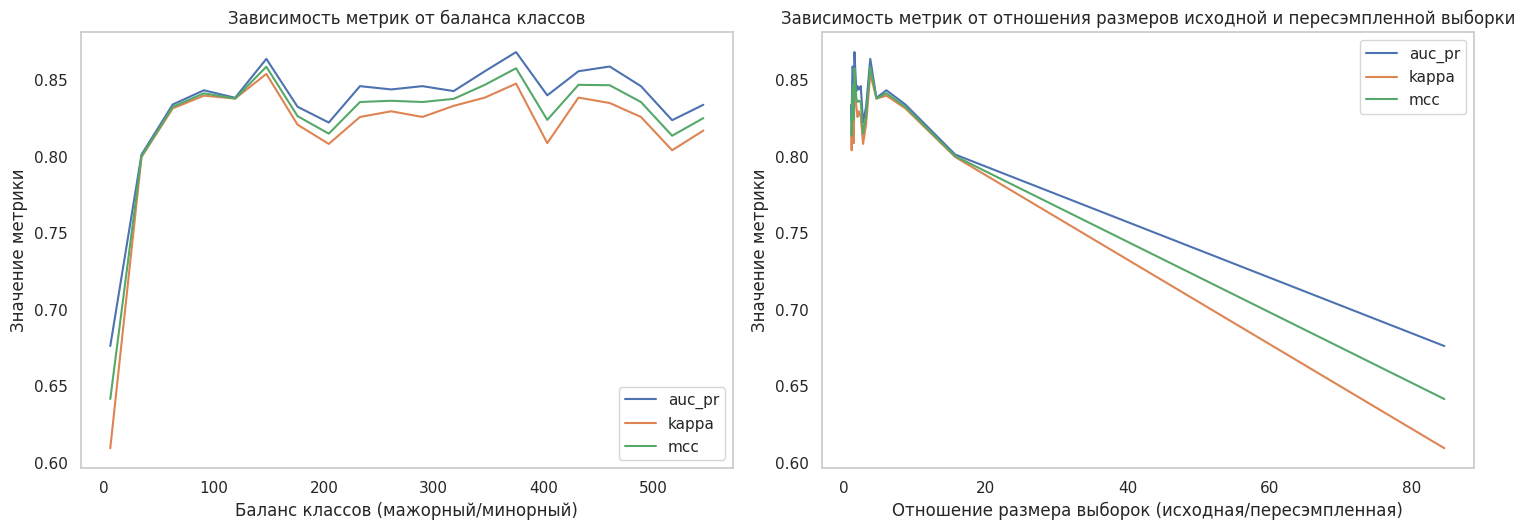

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for metric in ['auc_pr', 'kappa', 'mcc']:
    plt.plot(metrics['sample_balance'], metrics[metric], label=metric)
plt.xlabel('Баланс классов (мажорный/минорный)')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от баланса классов')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
for metric in ['auc_pr', 'kappa', 'mcc']:
    plt.plot(metrics['sample_ratio'], metrics[metric], label=metric)
plt.xlabel('Отношение размера выборок (исходная/пересэмпленная)')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от отношения размеров исходной и пересэмпленной выборки')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
best_idx = np.argmax(metrics['mcc'])

best_sample_balance = metrics['sample_balance'][best_idx]
best_sample_ratio = metrics['sample_ratio'][best_idx]
best_ratio = ratios[best_idx]
best_mcc = metrics['mcc'][best_idx]

print('Оптимальный sample_balance:', round(best_sample_balance, 1))
print('Оптимальный sample_ratio:', round(best_sample_ratio, 3))

rus = RandomUnderSampler(sampling_strategy={0: int(sum(y_train == 0) * best_ratio)}, random_state=52)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

catboost_rus = CatBoostClassifier(iterations=100, verbose=False)

categorical_features = ['Hour', 'Day']
catboost_rus.fit(X_train_res, y_train_res, cat_features=categorical_features)

print('\ntest AUC-PR:', round(auc_pr(y_test, catboost_rus.predict(X_test)), 3))
print('test kappa:', round(kappa_coef(y_test, catboost_rus.predict(X_test)), 3))
print('test mcc:', round(mcc(y_test, catboost_rus.predict(X_test)), 3))

Оптимальный sample_balance: 147.5
Оптимальный sample_ratio: 3.678

test AUC-PR: 0.745
test kappa: 0.744
test mcc: 0.744


**Вывод:** Результаты на тестовой выборке получились чуть лучше (кроме auc-pr, там небольшая просадка), чем у безлайн модели.

Даже такой наивный подход может дать относительно неплохие результаты и улучшить наши метрики. Тем не менее, сейчас мы никак не используем информацию о распределении объектов в выборке. Оказывается, что даже относительно простые эвристические правила могут заметно поднять нам качество - например, мы можем при отбрасывании использовать близость отдельных объектов мажорного класса к минорному и отбрасывать самые близкие. Протестируйте алгоритм [Near-Miss](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf) на наших данных и постройте графики, аналогичные предыдущему пункту (также добавьте график с зависимостью качества от числа соседей).

In [ ]:
from imblearn.under_sampling import NearMiss

ratios = np.linspace(0.01, 1.0, 20)
metrics = {
    'auc_pr': [],
    'kappa': [],
    'mcc': [],
    'sample_balance': [],
    'sample_ratio': []
}

for ratio in tqdm(ratios):
    nm = NearMiss(sampling_strategy={0: int(sum(y_train == 0) * ratio)})
    X_train_res, y_train_res = nm.fit_resample(X_train, y_train)

    catboost_nm= CatBoostClassifier(iterations=100, verbose=False)

    categorical_features = ['Hour', 'Day']
    catboost_nm.fit(X_train_res, y_train_res, cat_features=categorical_features)

    metrics['auc_pr'].append(auc_pr(y_val, catboost_nm.predict(X_val)))
    metrics['kappa'].append(kappa_coef(y_val, catboost_nm.predict(X_val)))
    metrics['mcc'].append(mcc(y_val, catboost_nm.predict(X_val)))
    metrics['sample_balance'].append(sum(y_train_res == 0)/sum(y_train_res == 1))
    metrics['sample_ratio'].append(len(X_train)/len(X_train_res))

100%|██████████| 20/20 [04:32<00:00, 13.64s/it]


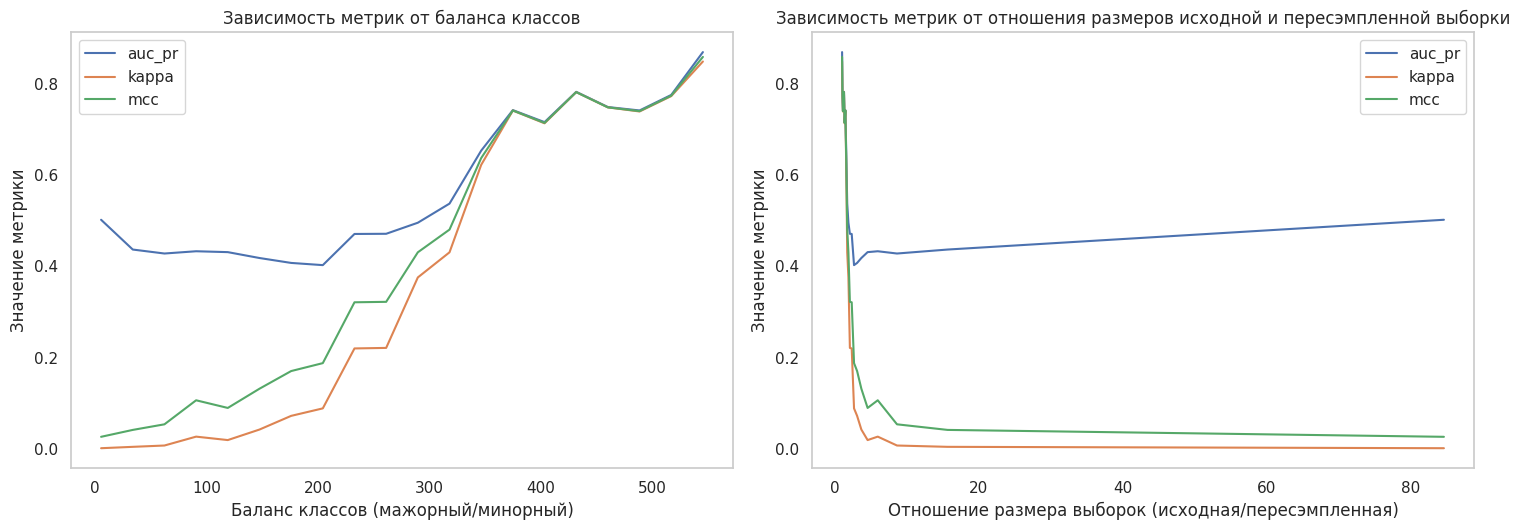

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for metric in ['auc_pr', 'kappa', 'mcc']:
    plt.plot(metrics['sample_balance'], metrics[metric], label=metric)
plt.xlabel('Баланс классов (мажорный/минорный)')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от баланса классов')
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
for metric in ['auc_pr', 'kappa', 'mcc']:
    plt.plot(metrics['sample_ratio'], metrics[metric], label=metric)
plt.xlabel('Отношение размера выборок (исходная/пересэмпленная)')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от отношения размеров исходной и пересэмпленной выборки')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
best_idx = np.argmax(metrics['mcc'])

best_sample_balance = metrics['sample_balance'][best_idx]
best_sample_ratio = metrics['sample_ratio'][best_idx]
best_ratio = ratios[best_idx]

print('Оптимальный sample_balance:', round(best_sample_balance, 1))
print('Оптимальный sample_ratio:', round(best_sample_ratio, 3))

Оптимальный sample_balance: 545.4
Оптимальный sample_ratio: 1.0


В нашем случае получается, что оптимальным является не изменять отношение выборк (исходная/пересэмпленная)

In [ ]:
n_neighbors_range = range(1, 11)
metrics = {
    'auc_pr': [],
    'kappa': [],
    'mcc': [],
    'n_neighbors': [],
}

for n_neighbors in tqdm(n_neighbors_range):
    nm = NearMiss(sampling_strategy={0: int(sum(y_train == 0)*best_ratio)}, n_neighbors=n_neighbors)
    X_train_res, y_train_res = nm.fit_resample(X_train, y_train)

    catboost_nm= CatBoostClassifier(iterations=100, verbose=False)

    categorical_features = ['Hour', 'Day']
    catboost_nm.fit(X_train_res, y_train_res, cat_features=categorical_features)

    metrics['auc_pr'].append(auc_pr(y_val, catboost_nm.predict(X_val)))
    metrics['kappa'].append(kappa_coef(y_val, catboost_nm.predict(X_val)))
    metrics['mcc'].append(mcc(y_val, catboost_nm.predict(X_val)))
    metrics['n_neighbors'].append(n_neighbors)

100%|██████████| 10/10 [04:23<00:00, 26.31s/it]


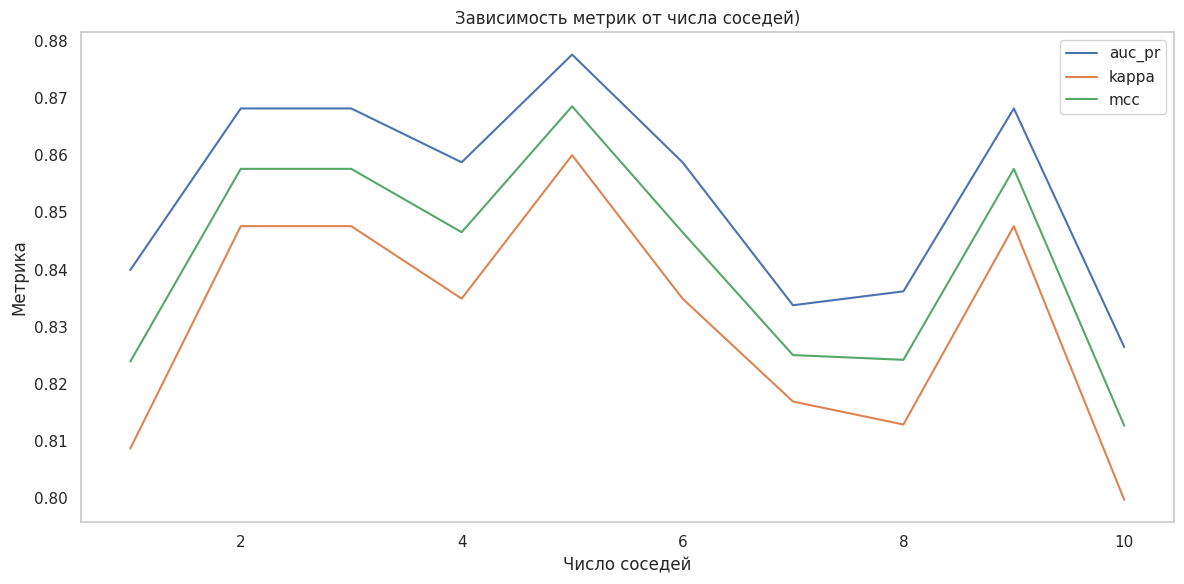

In [ ]:
plt.figure(figsize=(12, 6))

for metric in ['auc_pr', 'kappa', 'mcc']:
    plt.plot(metrics['n_neighbors'], metrics[metric], label=metric)
plt.xlabel('Число соседей')
plt.ylabel('Метрика')
plt.title('Зависимость метрик от числа соседей)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
best_idx = np.argmax(metrics['mcc'])

best_n_neighbors = metrics['n_neighbors'][best_idx]

print('Оптимальный n_neighbors:', best_n_neighbors)

nm = NearMiss(sampling_strategy={0: int(sum(y_train == 0)*best_ratio)}, n_neighbors=best_n_neighbors)
X_train_res, y_train_res = nm.fit_resample(X_train, y_train)

catboost_nm= CatBoostClassifier(iterations=100, verbose=False)

categorical_features = ['Hour', 'Day']
catboost_nm.fit(X_train_res, y_train_res, cat_features=categorical_features)

print('\ntest AUC-PR:', round(auc_pr(y_test, catboost_nm.predict(X_test)), 3))
print('test kappa:', round(kappa_coef(y_test, catboost_nm.predict(X_test)), 3))
print('test mcc:', round(mcc(y_test, catboost_nm.predict(X_test)), 3))

Оптимальный n_neighbors: 5

test AUC-PR: 0.73
test kappa: 0.718
test mcc: 0.724


**Вывод:** Результаты на тестовой выборке на 2-3 % хуже (кроме kappa coef, он на том же уровне), чем у безлайна и метода RandomUnderSampler, но зато нет зависимости от random_state.

**Бонус (1 балл)**. imblearn также предлагает много различных методов для андерсэмплинга. Выберите что-нибудь еще из предлагаемого на свой вкус, опишите идею метода и протестируйте его.


EditedNearestNeighbours (ENN) - это метод очистки выборки, который удаляет из мажоритарного класса те объекты, которые не согласуются с ближайшими соседями. Если точка окружена соседями другого класса, она считается подозрительной и удаляется. Это помогает уменьшить шум и перекрытие между классами.

В отличие от RandomUnderSampler и NearMiss, часто работает без явного подбора sampling_strategy — автоматически удаляет только шумные объекты, сохраняя естественное распределение (не нужен жесткий баланс классов), но данный метод более медленный.

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_res, y_train_res = enn.fit_resample(X_train, y_train)

catboost_enn = CatBoostClassifier(iterations=100, verbose=False)
categorical_features = ['Hour', 'Day']
catboost_enn.fit(X_train_res, y_train_res, cat_features=categorical_features)

print('val AUC-PR:', round(auc_pr(y_val, catboost_enn.predict(X_val)), 3))
print('test AUC-PR:', round(auc_pr(y_test, catboost_enn.predict(X_test)), 3))
print('val kappa:', round(kappa_coef(y_val, catboost_enn.predict(X_val)), 3))
print('test kappa:', round(kappa_coef(y_test, catboost_enn.predict(X_test)), 3))
print('val mcc:', round(mcc(y_val, catboost_enn.predict(X_val)), 3))
print('test mcc:', round(mcc(y_test, catboost_enn.predict(X_test)), 3))

val AUC-PR: 0.856
test AUC-PR: 0.758
val kappa: 0.838
test kappa: 0.75
val mcc: 0.847
test mcc: 0.754


**Вывод:** Результаты на тестовой выборке получились максимальными среди всех моделей (на 1-3 % лучше, чем у безлайна), и тут мы даже на подбирали sampling_strategy, что говорит о превосходстве данного метода.

# Часть 2. Поиск аномалий.

Как вы могли заметить, методы балансировки выборок очень часто могут привести к не самым лучшим результатам из-за того, что они по сути искажают информацию о реальном распределении данных - в реальности обычно требуется долгий подбор в принципе работоспособных для задачи методов и их аккуратная настройка.

Теперь давайте попробуем слегка сменить постановку задачи и переключиться на задачу "одноклассовой" классификации, то есть - поиска *аномалий* в выборке. В общем-то, это вполне согласуется с нашей областью работы - мы действительно можем назвать мошеннические транзакции аномальньми (как интуитивно, так и на основании наблюдаемой балансировки данных).

Стоит отметить, что методы обнаружения аномалий чаще всего относятся к классу методов обучения без учителя. Это дает некоторый положительный эффект - нам не обязательно нужно тратить время на разметку данных (тем не менее, для контроля качества какую-то часть разметить все-таки придется). Впрочем, чаще всего перфоманс таких методов оказывается заметно хуже, чем у честного обучения с учителем (если мы можем себе его позволить).



**Задание 4. (3 балла).** На занятиях вы разбирали схожий с Random Forest подход для детекции аномалий без известной разметки данных, называемый Isolation Forest. Напомним суть: на этапе обучения мы создаем ансамбль из решающих деревьев, в котором признак и порог на каждую вершину подбираются случайно. Затем мы считаем для объектов оценку аномальности через длину пути до соответствующего листа в каждом дереве.

В данном задании вам предлагается реализовать модификацию данного алгоритма, известную как Extended Isolation Forest. В ней мы на каждом шаге будем определять не порог для признака, а полноценную случайную гиперплоскость, разбивающую выборку на 2 части. С детальным описанием вы можете ознакомиться [здесь](https://arxiv.org/pdf/1811.02141.pdf).

Ниже приведен шаблон кода. Постарайтесь работать в его рамках (минорные изменения вполне допустимы, главное не переворачивайте всю структуру с ног на голову).

**NB**: будем считать, что в нашем датасете нет категориальных признаков - можете не заморачиваться с их обработкой (но в общем случае, это будет важно).

**Советы**:
 - Численные признаки лучше предобработать надлежащим образом.
 - Возможно, вам поможет выбрасывание некоторых признаков.
 - Внимательно следите за знаками.
 - Не игнорируйте документирующие строки.
 - Вероятнее всего, вы не сможете приблизиться по качеству к supervised-решениям. Если у вас не получается это сделать (но вы уверены в своей правоте), не стоит тратить слишком много времени на поиск ошибок.
- При желании, можете вынести этот код в отдельный файл и приложить его к ноутбуку. Он довольно громоздкий и в ноутбуке такое плохо читается.


**Бонусы (каждый по 0.5)**:
- Сделайте ваш EIF параллельным (`multiprocessing`, `joblib`).
- Добавьте возможность откатиться к дефолтному варианту Isolation Forest. (порассуждайте, как можно реализовать это в данной модели?):


**Я добавил возможность откатиться к дефолтному варианту Isolation Forest:**
Обычный Isolation Forest отличается от Extended только способом построения разделяющих гиперплоскостей:

IF: Выбирает случайный признак и значение для разделения.

EIF: Использует случайные гиперплоскости (w и b).

In [29]:
def c_factor(n):
    """
    Computes average path length for an unsuccessful search in a binary search tree.
    Params:
        n: int - number of data points for BST
    """
    if n <= 1:
        return 0
    elif n == 2:
        return 1

    return 2*(np.log(n-1) + 0.5772156649) - (2*(n-1)/n)

def calc_height(X, depth, node):
    """
    Calculates anomaly scores for sample in a recursive manner.
    Params:
        X: np.array - current sample, available to node

        depth: int - path length up to current node

        node: Node - current tree node

    Returns:
        scores: int, float or np.array - anomaly scores for sample
    """
    scores = np.zeros(X.shape[0])

    if node.kind == 'external':
        scores[:] = depth + c_factor(node.size)
        return scores

    dot = np.dot(X-node.b, node.w)

    left_mask = dot <= 0
    right_mask = ~left_mask

    if np.any(left_mask):
        scores[left_mask] = calc_height(X[left_mask], depth+1, node.left)
    if np.any(right_mask):
        scores[right_mask] = calc_height(X[right_mask], depth+1, node.right)

    return scores

class Node(object):
    """
    A single node object for each tree. Contains information on height, current data,
    splitting hyperplane and children nodes.

    Attributes:
        X: np.array - data available to current node
        size: int - length of available data

        depth: int - depth of node

        left: Node - left child
        right: Node - right child

        kind: str - either "internal" or "external", indicates the type of current node

        w: np.array - normal vector for the splitting hyperplane
        b: float - intercept term for the splitting hyperplane
    """
    def __init__(self, X, depth, left, right, kind, w, b):
        """
        Node(h, left, right, kind, w, b)
        Represents the node object.

        Params:
            X: np.array - data available to current node
            depth: int - depth of node

            left: Node - left child
            right: Node - right child

            kind: str - either "internal" or "external", indicates the type of current node

            w: np.array - normal vector for the splitting hyperplane
            b: float - intercept term for the splitting hyperplane

        """
        self.size = len(X)

        self.depth = depth

        self.left = left
        self.right = right

        self.kind = kind

        self.w = w
        self.b = b

    def __repr__(self):
        """
        For convenience only.
        """
        return f"Node(size={self.size}, depth={self.depth}, kind={self.kind})"

class RandomizedTree(object):
    """
    Single randomized tree object. Stores root and its depth (tree is built recursively).
    Attributes:
        depth: int - current tree depth

        max_depth: int - maximum tree depth

        root: Node - root node

        internal_count: int - number of internal nodes

        external_count: int - number of external nodes

    """
    def __init__(self, X, max_depth, extended=True):
        """
        Single randomized tree object. Stores root and its depth (tree is built recursively).
        Params:
            X: np.array - train sample
            max_depth: int - maximum tree depth

        """
        self.depth = 0
        self.max_depth = max_depth

        self.internal_count = 0
        self.external_count = 0

        self.extended = extended

        self.root = self.grow(X, 0)

    def __repr__(self):
        """
        For convenience only.
        """

        return f"RandomizedTree(depth={self.depth}, max_depth={self.max_depth}, n_internal={self.internal_count}, n_external={self.external_count})"

    def grow(self, X, depth):
        """
        Grow tree in a recursive manner.
        Params:
            X: np.array - available train sample

            depth: int - current tree depth

        Returns:
            node: Node - a trained node with separating hyperplane data.
                         Node provides access to children if necessary (these are built recursively)
        """
        if depth >= self.max_depth or len(X) <= 1:
            self.external_count += 1
            return Node(X, depth, None, None, 'external', None, None)

        if self.extended:
            # разбиение по случайной гиперплоскости (EIF)
            w = np.random.normal(size=X.shape[1])
            b = np.random.uniform(low=np.min(X, axis=0), high=np.max(X, axis=0))
        else:
            # разбиение по случайному признаку (IF)
            feature_index = np.random.randint(0, X.shape[1])
            w = np.zeros(X.shape[1])
            w[feature_index] = 1
            b = np.random.uniform(low=np.min(X[:, feature_index]), high=np.max(X[:, feature_index]))

        dot = np.dot(X-b, w)

        left_mask = dot <= 0
        right_mask = ~left_mask

        left = self.grow(X[left_mask], depth + 1)
        right = self.grow(X[right_mask], depth + 1)

        self.internal_count += 1

        return Node(X, depth, left, right, 'internal', w, b)

    def score_samples(self, X):
        """
        Calculate anomaly scores for given data. You may utilize outer function `calc_height`.
        Params:
            X: np.array - data to be evaluated

        Returns:
            scores: np.array - estimated anomaly scores
        """
        scores = calc_height(X, 0, self.root)

        return scores

class ExtendedIsolationForest(object):
    """
    Extended Isolation Forest object. Stores training data and trained randomized trees.
    Attributes:
        n_trees: int - number of Randomized Trees

        max_depth: int - maximum depth of each tree

        subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

        trees: list - container for trained trees

        contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

    """

    def __init__(self, n_trees, subsample_rate, max_depth=None, contamination=0.01, extended=True):
        """
        Extended Isolation Forest object. Stores training data and trained randomized trees.
        Params:
            n_trees: int - number of Randomized Trees

            subsample_rate: float - draw `subsample_rate * X.shape[0]` samples for each tree

            max_depth: int or None - maximum depth of each tree. Defaults to ceil(log_2(subsample_size)) if not provided

            contamination: float - estimated fraction of anomaly samples in data. Used for thresholding

        """
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.subsample_rate = subsample_rate
        self.extended = extended
        self.trees = []
        self.contamination = contamination
        self.is_fit = False
        self.data_points_q = None

    def __repr__(self):
        """For convenience only."""

        return f"ExtendedIsolationForest(n_trees={self.n_trees}, max_depth={self.max_depth}, subsample_rate={self.subsample_rate}, contamination={self.contamination}, is_fit={self.is_fit})"

    def fit(self, X):
        """
        Fit EIF to new data.
        Params:
            X: np.array - 2d array of samples
        """
        self.data_points_q  = int(self.subsample_rate * X.shape[0])

        if self.max_depth is None:
            self.max_depth = np.ceil(np.log2(self.data_points_q))

        np.random.seed(52)

        for _ in tqdm(range(self.n_trees)):
            subsample_indexes = np.random.choice(X.shape[0], size=self.data_points_q , replace=False)
            self.trees.append(RandomizedTree(X[subsample_indexes], self.max_depth, self.extended))

        self.is_fit = True
        return self

    def score_samples(self, X):
        """
        Estimate (normalized) anomaly score for each given sample
        Params:
            X: np.array - new samples

        Returns:
            scores: np.array - anomaly scores (larger value means higher probability of a sample being an outlier)
        """
        path_lengths = np.zeros(X.shape[0])

        for tree in tqdm(self.trees):
            path_lengths += tree.score_samples(X)

        mean_path_lengths = path_lengths / len(self.trees)
        scores = 2 ** -(mean_path_lengths / c_factor(self.data_points_q))

        return scores

    def predict(self, X):
        """
        Predict if given samples are outliers.
        Params:
            X: np.array - new samples

        Returns:
            labels: np.array - anomaly labels (1 for outliers, 0 for inliers)
        """
        scores = self.score_samples(X)
        threshold = np.quantile(scores, (1 - self.contamination))
        labels = (scores >= threshold).astype(int)

        return labels, scores

**Задание 5. (1 балл).** Протестируйте вашу реализацию EIF и подберите оптимальные гиперпараметры (наш метод не использует разметку, поэтому можете попробовать делать это на обучающей выборке). Сравните ее с обычным IF из `sklearn` (желательно делать это на одних и тех же параметрах). Удалось ли сделать лучше?

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

Тестируем две реализации:

In [82]:
eif = ExtendedIsolationForest(n_trees = 10, subsample_rate = 0.1, extended=True)

eif.fit(X_train_scaled)

test_pred, scores = eif.predict(X_test_scaled)
print('test auc-pr:', auc_pr(y_test, test_pred))
print('test kappa:', kappa_coef(y_test, test_pred))
print('test mcc:', mcc(y_test, test_pred))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

test auc-pr: 0.24502725368214645
test kappa: 0.06380390526904328
test mcc: 0.12417959298781006


In [83]:
if_ = ExtendedIsolationForest(n_trees = 10, subsample_rate = 0.1, extended=False)

if_.fit(X_train_scaled)

test_pred, scores = if_.predict(X_test_scaled)
print('test auc-pr:', auc_pr(y_test, test_pred))
print('test kappa:', kappa_coef(y_test, test_pred))
print('test mcc:', mcc(y_test, test_pred))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

test auc-pr: 0.36734776932628127
test kappa: 0.09642397825618679
test mcc: 0.18766704520088212


Подбираем оптимальные гиперпараметры EIF:

In [46]:
def objective(trial):
    params = {
        'n_trees': trial.suggest_int('n_trees', 10, 50),
        'subsample_rate': trial.suggest_float('subsample_rate', 0.1, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
    }

    eif = ExtendedIsolationForest(
        n_trees=params['n_trees'],
        subsample_rate=params['subsample_rate'],
        max_depth=params['max_depth'],
        extended=True
    )

    eif.fit(X_train_scaled)
    train_pred, scores = eif.predict(X_train_scaled)
    train_auc_pr = auc_pr(y_train, train_pred)
    train_kappa = kappa_coef(y_train, train_pred)
    train_mcc = mcc(y_train, train_pred)

    train_metric = (train_auc_pr+train_kappa+train_mcc)/3
    return train_metric

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best parameters:", study.best_params)
best_params = study.best_params

[I 2025-05-07 13:08:42,359] A new study created in memory with name: no-name-d0dece8b-6eef-405c-b367-9c72287af6d4


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-07 13:11:02,481] Trial 0 finished with value: 0.27769315017314455 and parameters: {'n_trees': 49, 'subsample_rate': 0.6447709858481715, 'max_depth': 17}. Best is trial 0 with value: 0.27769315017314455.


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-07 13:12:09,394] Trial 1 finished with value: 0.2872700201479223 and parameters: {'n_trees': 49, 'subsample_rate': 0.11630920221041514, 'max_depth': 16}. Best is trial 1 with value: 0.2872700201479223.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-05-07 13:12:55,407] Trial 2 finished with value: 0.29684689012270316 and parameters: {'n_trees': 20, 'subsample_rate': 0.45651656002702323, 'max_depth': 18}. Best is trial 2 with value: 0.29684689012270316.


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

[I 2025-05-07 13:13:21,464] Trial 3 finished with value: 0.2521548302403998 and parameters: {'n_trees': 19, 'subsample_rate': 0.42269464295521697, 'max_depth': 11}. Best is trial 2 with value: 0.29684689012270316.


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

[I 2025-05-07 13:14:48,280] Trial 4 finished with value: 0.2840777301563308 and parameters: {'n_trees': 41, 'subsample_rate': 0.7748515386108324, 'max_depth': 13}. Best is trial 2 with value: 0.29684689012270316.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-05-07 13:15:18,049] Trial 5 finished with value: 0.258539410223586 and parameters: {'n_trees': 10, 'subsample_rate': 0.917987806858397, 'max_depth': 16}. Best is trial 2 with value: 0.29684689012270316.


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

[I 2025-05-07 13:15:32,468] Trial 6 finished with value: 0.2564112168958562 and parameters: {'n_trees': 26, 'subsample_rate': 0.23249623138875566, 'max_depth': 5}. Best is trial 2 with value: 0.29684689012270316.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-07 13:17:18,731] Trial 7 finished with value: 0.26918037686222857 and parameters: {'n_trees': 50, 'subsample_rate': 0.7650243982635293, 'max_depth': 13}. Best is trial 2 with value: 0.29684689012270316.


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[I 2025-05-07 13:18:15,653] Trial 8 finished with value: 0.2564112168958562 and parameters: {'n_trees': 28, 'subsample_rate': 0.5120365088310759, 'max_depth': 16}. Best is trial 2 with value: 0.29684689012270316.


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

[I 2025-05-07 13:18:51,569] Trial 9 finished with value: 0.2553471202319913 and parameters: {'n_trees': 49, 'subsample_rate': 0.7485097615641485, 'max_depth': 4}. Best is trial 2 with value: 0.29684689012270316.


Best parameters: {'n_trees': 20, 'subsample_rate': 0.45651656002702323, 'max_depth': 18}


In [84]:
best_eif = ExtendedIsolationForest(
    n_trees=best_params['n_trees'],
    subsample_rate=best_params['subsample_rate'],
    max_depth=best_params['max_depth'],
    extended=True
)

best_eif.fit(X_train_scaled)

test_pred, scores = best_eif.predict(X_test_scaled)
print('test auc-pr:', auc_pr(y_test, test_pred))
print('test kappa:', kappa_coef(y_test, test_pred))
print('test mcc:', mcc(y_test, test_pred))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

test auc-pr: 0.26949135681097336
test kappa: 0.070327919866472
test mcc: 0.13687708343042446


In [75]:
from sklearn.ensemble import IsolationForest

if_sklearn = IsolationForest(
    n_estimators=best_params['n_trees'],
    max_samples=best_params['max_depth'],
    contamination = 0.1
)

if_sklearn.fit(X_train)
test_pred = if_sklearn.predict(X_test)
test_pred = np.where(test_pred == -1, 1, 0)

print('test auc-pr:', auc_pr(y_test, test_pred))
print('test kappa:', kappa_coef(y_test, test_pred))
print('test mcc:', mcc(y_test, test_pred))

test auc-pr: 0.23064795099504892
test kappa: 0.010977446691994559
test mcc: 0.04847222382922096


**Вывод:** Обе модели показывают очень низкие результаты, но EIF с подобранными гиперпараметрами немного лучше, чем обычный IF из sklearn с теми же параметрами.

Возможно, ваш алгоритм выдал большие оценки объектам с негативной разметкой. Постарайтесь выбрать несколько таких объектов и доступно объяснить (= с кодом и графиками), почему так вышло:

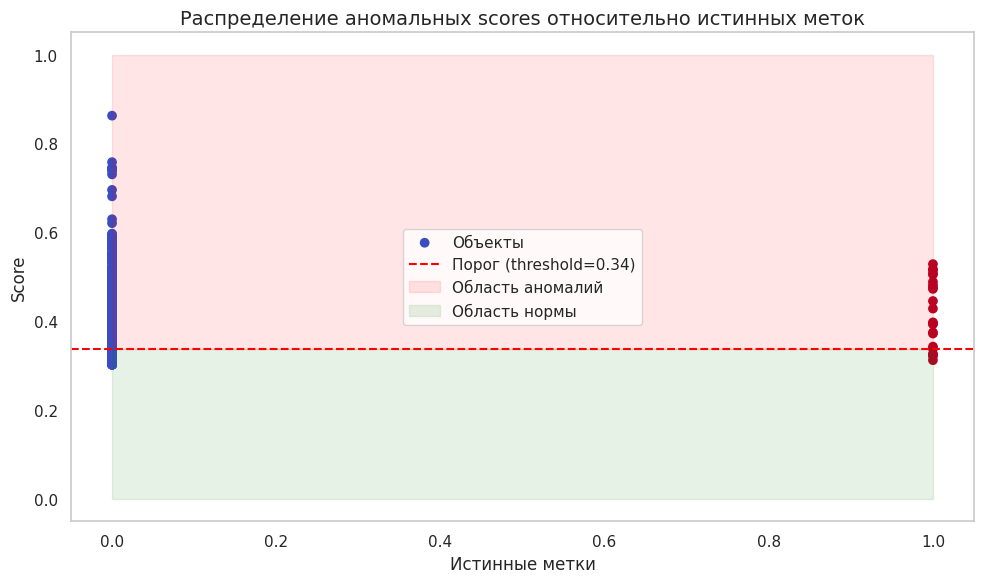

In [94]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, scores, c=y_test, cmap='coolwarm', label='Объекты')

threshold = np.quantile(scores, 0.9)
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Порог (threshold={round(threshold, 2)})')

plt.title('Распределение аномальных scores относительно истинных меток', fontsize=14)
plt.xlabel('Истинные метки', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.fill_between([0, 1], threshold, 1, color='red', alpha=0.1, label='Область аномалий')
plt.fill_between([0, 1], 0, threshold, color='green', alpha=0.1, label='Область нормы')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()

**Вывод:** Видим, что алгоритм действительно выдал большие оценки объектам, которые являются нормальными, но зато только малая часть реальных аномалий была определена как норма.

Выберем 20 негативных объектов с наибольшем score:

In [96]:
sort_indexes = np.argsort(scores[y_test == 0])

In [122]:
X_test[y_test == 0]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour,Day
256327,-0.374887,-4.117293,-4.187522,1.183738,-0.310090,-0.899450,2.725253,-0.949894,-0.171054,-0.383950,-1.432924,-0.233955,-0.173061,1.155799,0.060992,-0.437635,-0.227381,-0.285719,-0.113895,2.467233,1.015104,0.086303,-1.426768,-0.596596,0.204410,0.927533,-0.398025,0.125555,1336.00,19,1
256326,1.985106,0.398793,-2.451505,1.462487,1.035466,-0.846500,0.679494,-0.305204,0.198212,-0.363112,-0.798523,-0.274237,-0.662817,-0.917639,-0.260083,-0.145070,0.953649,0.156307,-0.361630,-0.184153,-0.038611,0.008407,-0.037846,0.383466,0.482723,-0.511534,-0.009908,-0.019809,38.17,19,1
256328,-0.041673,0.712444,0.335351,-0.670760,0.428873,-0.811848,0.810955,0.007803,-0.190866,-0.223122,0.766145,0.468258,-0.861865,0.474580,-0.976568,0.054839,-0.527432,-0.274296,0.107782,-0.077453,-0.203472,-0.485264,0.089008,-0.010075,-0.570358,0.123357,0.240496,0.086646,1.98,19,1
256329,-0.832503,0.682724,1.022189,-0.717397,0.427839,1.585504,-0.335735,1.113388,0.019252,-1.051411,0.457362,0.342512,-1.108039,0.693400,0.766083,-0.356980,0.172194,-0.434131,-0.166895,-0.309253,0.000010,-0.032568,-0.033124,-1.699208,-0.504059,-0.412187,0.073561,0.052377,3.99,19,1
256331,0.177244,0.917211,-0.688701,-0.679315,1.123262,-0.432962,0.867040,0.024838,0.182590,-0.806064,-1.400912,-0.968885,-1.148431,-0.797625,-0.009105,0.510401,0.272376,0.049245,-0.062383,-0.045220,-0.389600,-1.026759,0.045041,-0.113254,-0.396547,0.159356,0.216029,0.075020,4.49,19,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,23,1
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,23,1
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,23,1
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,23,1


Видим, что все такие транзакции были проведены с 20 до 23 первого дня, то есть наш алгоритм, почему-то плохо работает с вечерним временем первого дня, возможно, это связано с какими-то признаками V, которые в это время очень похожи на аномальные объекты.

Также я нашел в Wikipedia: основным ограничением стандартных методов, основанных на расстоянии, является их неэффективность при работе с данными высокой размерности. Основная причина в том, что в пространстве высокой размерности каждая точка одинаково разрежена, поэтому использование меры разделения на основе расстояния неэффективно. К сожалению, данные высокой размерности также влияют на эффективность обнаружения iForest, но производительность можно значительно улучшить, используя выбор признаков, например, куртозис, для уменьшения размерности выборки.

В нашем случае 28 признаков V, что говорит о высокой размерности, поэтому алгоритм работает неэффективно.

**Задание 6. (1 балл).** `sklearn` также предлагает нам и другие методы для поиска аномалий. В этом задании мы предлагаем вам сделать следующее:

Для начала попробуйте использовать методы Local Outlier Factor и One-Class SVM. Сравните результаты с IF и EIF.  

In [123]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

In [181]:
lof = LocalOutlierFactor(contamination=0.1, novelty=True)
lof.fit(X_train_scaled)
test_scores = -lof.score_samples(X_test_scaled)
test_pred = np.where(test_scores > np.quantile(test_scores, 0.9), 1, 0)

print('test auc-pr:', auc_pr(y_test, test_pred))
print('test kappa:', kappa_coef(y_test, test_pred))
print('test mcc:', mcc(y_test, test_pred))

test auc-pr: 0.0003862223938766195
test kappa: -0.001535401058710372
test mcc: -0.009267696356944298


In [128]:
ocsvm = OneClassSVM(nu=0.1)
ocsvm.fit(X_train_scaled)
test_scores = -ocsvm.score_samples(X_test_scaled)
test_pred = np.where(test_scores > np.quantile(test_scores, 0.9), 1, 0)

print('test auc-pr:', auc_pr(y_test, test_pred))
print('test kappa:', kappa_coef(y_test, test_pred))
print('test mcc:', mcc(y_test, test_pred))

test auc-pr: 0.41232124370389184
test kappa: 0.01102741233436139
test mcc: 0.0665615726509456


**Вывод:** у Local Outlier Factor значения метрик получились около нулевыми, как бы я не пытался подобрать гиперпараметры, One-Class SVM выдал наибольший среди всех моделей AUC-PR, а остальные метрики на уровне IF.

У вас началась депрессия из-за плохих метрик? Не беда! Сейчас давайте сделаем так: все методы, опробованные в этой части, попробуем задействовать для создания дополнительных признаков в данных. Проделайте это (не забудьте, что обучаться здесь нужно на трейне). Теперь возьмите лучшую модель из предыдущей части и обучите на новых данных. Смогли ли unsupervised-методы повысить вам качество?

In [189]:
models = {
    'IF': IsolationForest(contamination=0.1),
    'EIF': ExtendedIsolationForest(n_trees=best_params['n_trees'], subsample_rate=best_params['subsample_rate'], max_depth=best_params['max_depth']),
    'LOF': LocalOutlierFactor(contamination=0.1, novelty=True),
    'OCSVM': OneClassSVM(nu=0.1)
}

X_train_new = X_train.copy()
X_test_new = X_test.copy()

for name, model in models.items():
    if name == 'EIF':
        model.fit(X_train_scaled)
        train_pred, train_scores = model.predict(X_train_scaled)
        test_pred, test_scores = model.predict(X_test_scaled)
        X_train_new[f'{name}_score'] = train_scores
        X_test_new [f'{name}_score'] = test_scores
    else:
        model.fit(X_train_scaled)
        X_train_new[f'{name}_score'] = -model.score_samples(X_train_scaled)
        X_test_new[f'{name}_score'] = -model.score_samples(X_test_scaled)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [198]:
X_train_new.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour,Day,IF_score,EIF_score,LOF_score,OCSVM_score
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0.388642,0.312437,1.079028,-2042.823208
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0.383350,0.310929,1.038278,-2024.570108
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,0.459362,0.324268,1.352409,-1026.605719
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0.422577,0.320528,1.213991,-1521.361776
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0.407871,0.314723,1.183927,-1921.134562


In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours

enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_new_res, y_train_res = enn.fit_resample(X_train_new, y_train)

In [200]:
catboost_enn = CatBoostClassifier(iterations=100, verbose=False)
categorical_features = ['Hour', 'Day']
catboost_enn.fit(X_train_new_res, y_train_res, cat_features=categorical_features)

print('test AUC-PR:', round(auc_pr(y_test, catboost_enn.predict(X_test_new)), 3))
print('test kappa:', round(kappa_coef(y_test, catboost_enn.predict(X_test_new)), 3))
print('test mcc:', round(mcc(y_test, catboost_enn.predict(X_test_new)), 3))

test AUC-PR: 0.682
test kappa: 0.682
test mcc: 0.682


**Вывод:** Лучшая модель с дополнительными признаками выдала качество на 7-8 % хуже, чем до этого.

Попробуем использовать безлайн:

In [197]:
catboost = CatBoostClassifier(iterations=100, verbose=False)
categorical_features = ['Hour', 'Day']
catboost.fit(X_train_new, y_train, cat_features=categorical_features)

print('test AUC-PR:', round(auc_pr(y_test, catboost.predict(X_test_new)), 3))
print('test kappa:', round(kappa_coef(y_test, catboost.predict(X_test_new)), 3))
print('test mcc:', round(mcc(y_test, catboost.predict(X_test_new)), 3))

test AUC-PR: 0.756
test kappa: 0.737
test mcc: 0.746


**Вывод:** Качество у AUC-PR немного просело, но зато немного выросли остальные метрики. :)

**Бонус. (0.1 балла).**

При сдаче проверяющий запустит следующую клетку один раз. Если она даст положительный результат, вы получите 0.1 бонусных балла. Если она даст отрицательный результат, вы получите -0.1 бонусных балла.

Если вы хотите отказаться от сдачи данного задания, допишите "хочу" после двоеточия: `хочу`

Ниже вы можете попрактиковаться и оценить ваши силы (изменять код ячейки запрещается!)

In [ ]:
import random

rng = random.SystemRandom(0)
rng.uniform(-1.0, 1.0)

0.9652510159308205